In [1]:
import glob, os, sys, vcf
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
plt.rcParams["figure.dpi"] = 150
import scipy.stats as st

# Extracting and analyzing data from the VCF files

## Don't need to do any QC filtering because that's for reads from FASTQ files

## These are all post-QC sequences in FASTA files

```bash
bash snp_calling/call_snps.sh sequences/genome/AY988601.1_BGD_CDS.fasta seq_for_analysis/P_whitmer_BGD.fasta alignments P_whitmer_BGD
```

In [3]:
# get all the Bangladesh isolates with clade annotations
P_whitmer = [(seq.id, list(str(seq.seq))) for seq in SeqIO.parse("seq_for_analysis/P_whitmer_BGD.fasta", "fasta")]

names, seqs = list(zip(*P_whitmer))
seq_df = pd.DataFrame({"Pos": np.arange(2130)+1})
seq_df = pd.concat([seq_df, pd.DataFrame(seqs).T], axis=1)

seq_df.columns = ["Pos"] + list(names)

In [2]:
def get_aln_snps(fName):
    '''
    This function gets all the SNPs present in an alignment. 
    '''
    
    if "G_" in fName:
        chrom = "gene=G"
        protein = "G"
    elif "P_" in fName:
        chrom = "gene=P"
        protein = "P"
    
    pos = []
    ref = []
    alt = []    
    
    vcf_reader = vcf.Reader(open(fName, 'r'))

    for record in vcf_reader:
        
        # check that all variants are coming from the correct gene. Might be overkill, but just another sanity check
        if chrom not in record.CHROM or record.CHROM != chrom:
            raise ValueError(f"SNP found outside of {chrom}")
            
        # convert form VCF objects to strings to do string comparison
        alt_alleles = [str(char) for char in record.ALT]

        if "<*>" in alt_alleles:
            alt_alleles.remove("<*>")
        alt_alleles = "".join(alt_alleles)
            
        pos.append(record.POS)
        ref.append(record.REF)
        alt.append(alt_alleles)
        
    return pd.DataFrame({"pos": pos, "ref": ref, "alt": alt})

In [3]:
def get_seq_df(fasta_file, isolates_lst):
    
    seqs = [(seq.id, str(seq.seq)) for seq in SeqIO.parse(fasta_file, "fasta") if seq.id in isolates_lst]
    seq_df = pd.DataFrame(seqs).rename(columns={0:"ID", 1:"Seq"})
    
    data_transf = seq_df.Seq.str.split("", expand=True).iloc[:, 1:-1].T.reset_index()
    data_transf.columns = ["Pos"] + list(seq_df.ID.values)
    
    return data_transf

In [4]:
def create_snp_matrix(fasta_file, isolates_lst, vcf_file):
    
    seq_df = get_seq_df(fasta_file, isolates_lst)
    vcf_df = get_aln_snps(vcf_file)
    
    # search for only sites that have been flagged as having SNPs using the variant caller (using bcftools, done earlier)
    variants_seq_df = seq_df.loc[seq_df.Pos.isin(vcf_df.pos.values)]
    
    # iterate through the positions in the above dataframe
    for pos in variants_seq_df.Pos.values:
    
        # iterate through every isolate (columns)
        for col in variants_seq_df.columns[1:]:

            if variants_seq_df.loc[variants_seq_df.Pos == pos, col].values[0] == vcf_df.loc[vcf_df.pos == pos, "ref"].values[0]:
                variants_seq_df.loc[variants_seq_df.Pos == pos, col] = 0
            else:
                variants_seq_df.loc[variants_seq_df.Pos == pos, col] = 1
              
    # separate the sites
    sites = variants_seq_df.Pos.values
    del variants_seq_df["Pos"]
    
    variants_seq_df = variants_seq_df.T
    variants_seq_df.columns = sites
                
    return sites, variants_seq_df

In [8]:
metadata = pd.read_csv("metadata_all.csv")

isolates_for_model = metadata.query("G == 1 & P == 1 & Country in ['India', 'Bangladesh', 'Malaysia']").ID.values
len(isolates_for_model)

P_snp_sites, P_snp_matrix = create_snp_matrix("sequences/PG/P_seqs.fasta", isolates_for_model, "alignments/P_for_linReg_SNPs.vcf")
G_snp_sites, G_snp_matrix = create_snp_matrix("sequences/PG/G_seqs.fasta", isolates_for_model, "alignments/G_for_linReg_SNPs.vcf")

P_snp_matrix.columns = ["P" + str(col) for col in P_snp_matrix.columns]
G_snp_matrix.columns = ["G" + str(col) for col in G_snp_matrix.columns]

input_mat = pd.concat([P_snp_matrix, G_snp_matrix], axis=1)
input_mat = input_mat.astype(int)
snp_cols = input_mat.columns
isolates = input_mat.index

# Next, encode every sequence in `P_whitmer` as a binary variable representing reference (0) or alternative (1) allele

# PCA of P and G sequences to look for clade clustering

## 1. PCA for all data to check separation by country 

In [7]:
def create_seq_df(metadata):

    # read in all fasta files

    P_all = pd.DataFrame([(seq.id, str(seq.seq)) for seq in SeqIO.parse("sequences/PG/P_seqs.fasta", "fasta")]).rename(columns={0: "ID", 1:"P_seq"})
    G_all = pd.DataFrame([(seq.id, str(seq.seq)) for seq in SeqIO.parse("sequences/PG/G_seqs.fasta", "fasta")]).rename(columns={0: "ID", 1:"G_seq"})

    P_unique = [seq.id for seq in SeqIO.parse("seq_for_analysis/P_deduplicated.fasta", "fasta")]
    G_unique = [seq.id for seq in SeqIO.parse("seq_for_analysis/G_deduplicated.fasta", "fasta")]
    
    seq_df = pd.merge(P_all, G_all, how="outer")
    
    # add variables for whether a sequence is part of the deduplicated sets (deduplication done randomly because metadata not significantly different to justify selecting a particular sequence)
    seq_df["P_dedup"] = seq_df["ID"].isin(P_unique).astype(int)
    seq_df["G_dedup"] = seq_df["ID"].isin(G_unique).astype(int)
    
    return seq_df.merge(metadata, on="ID", how="outer")

In [25]:
# Mapping to use for one-hot encoding. No nucleotide = missing because already checked that there are no indels in these seque
BASE_TO_COLUMN = {'A': 0, 'C': 1, 'T': 2, 'G': 3, 'N': 4}
COLUMN_TO_BASE = {0: "A", 1: "C", 2: "T", 3: "G"}

# Get one hot vector
def get_one_hot(sequence):

    if not pd.isnull(sequence):
        seq_in_index = np.array([BASE_TO_COLUMN.get(b, b) for b in sequence])

        one_hot = np.zeros((len(sequence), 4))

        # only get the non gap sites because otherwise we get indexing errors
        ind_non_gap = np.where(seq_in_index != 4)[0]

        # Assign the found positions to 1
        one_hot[ind_non_gap, seq_in_index[ind_non_gap]] = 1

        return one_hot
    else:
        return np.nan

In [9]:
def pca_elbow(mat, n, scale=False):
     
    if scale:
        scaler = StandardScaler()
        mat = scaler.fit_transform(mat)
    
    pca = PCA(n)
    pca.fit(mat)
    
    plt.plot(np.arange(n)+1, pca.explained_variance_ratio_)
    plt.xticks(np.arange(n)+1)
    
    plt.xlabel("PC")
    plt.ylabel("Proportion of Variance Explained")
    sns.despine()
    plt.show()

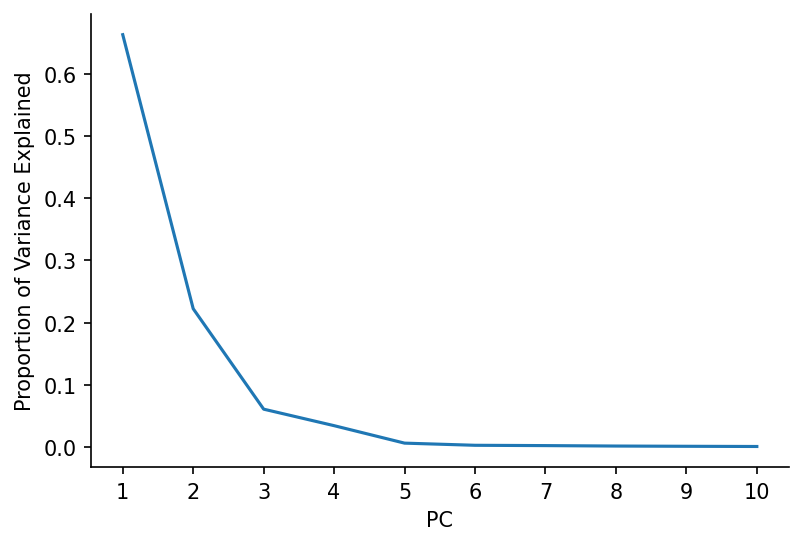

In [10]:
pca_elbow(np.cov(input_mat.values), 10)

In [13]:
def two_comp_PCA(snp_matrix, color_col):
    '''
    Perform PCA using the SNP matrix
    '''
    
    ncbi_ids = snp_matrix.index.values
    
    scaler = StandardScaler()
    X = scaler.fit_transform(snp_matrix.values)
    
    pca_10 = PCA(n_components=10)
    pca_10.fit(X)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(np.arange(1, 11), pca_10.explained_variance_ratio_)
    
    pca = PCA(n_components=2)
    X_new = pca.fit_transform(X)
    pca_df = pd.DataFrame(X_new).rename(columns={0: "PC1", 1:"PC2"})
    pca_df["ID"] = ncbi_ids
    
    sliced_metadata = metadata.loc[metadata.ID.isin(snp_matrix.index)]
    pca_df = pca_df.merge(sliced_metadata[["ID", "Country", "Clade"]], on="ID")
        
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=color_col, alpha=0.7, s=50, ax=ax[1])
    sns.despine()
    plt.show()
    
    return X, pca_df

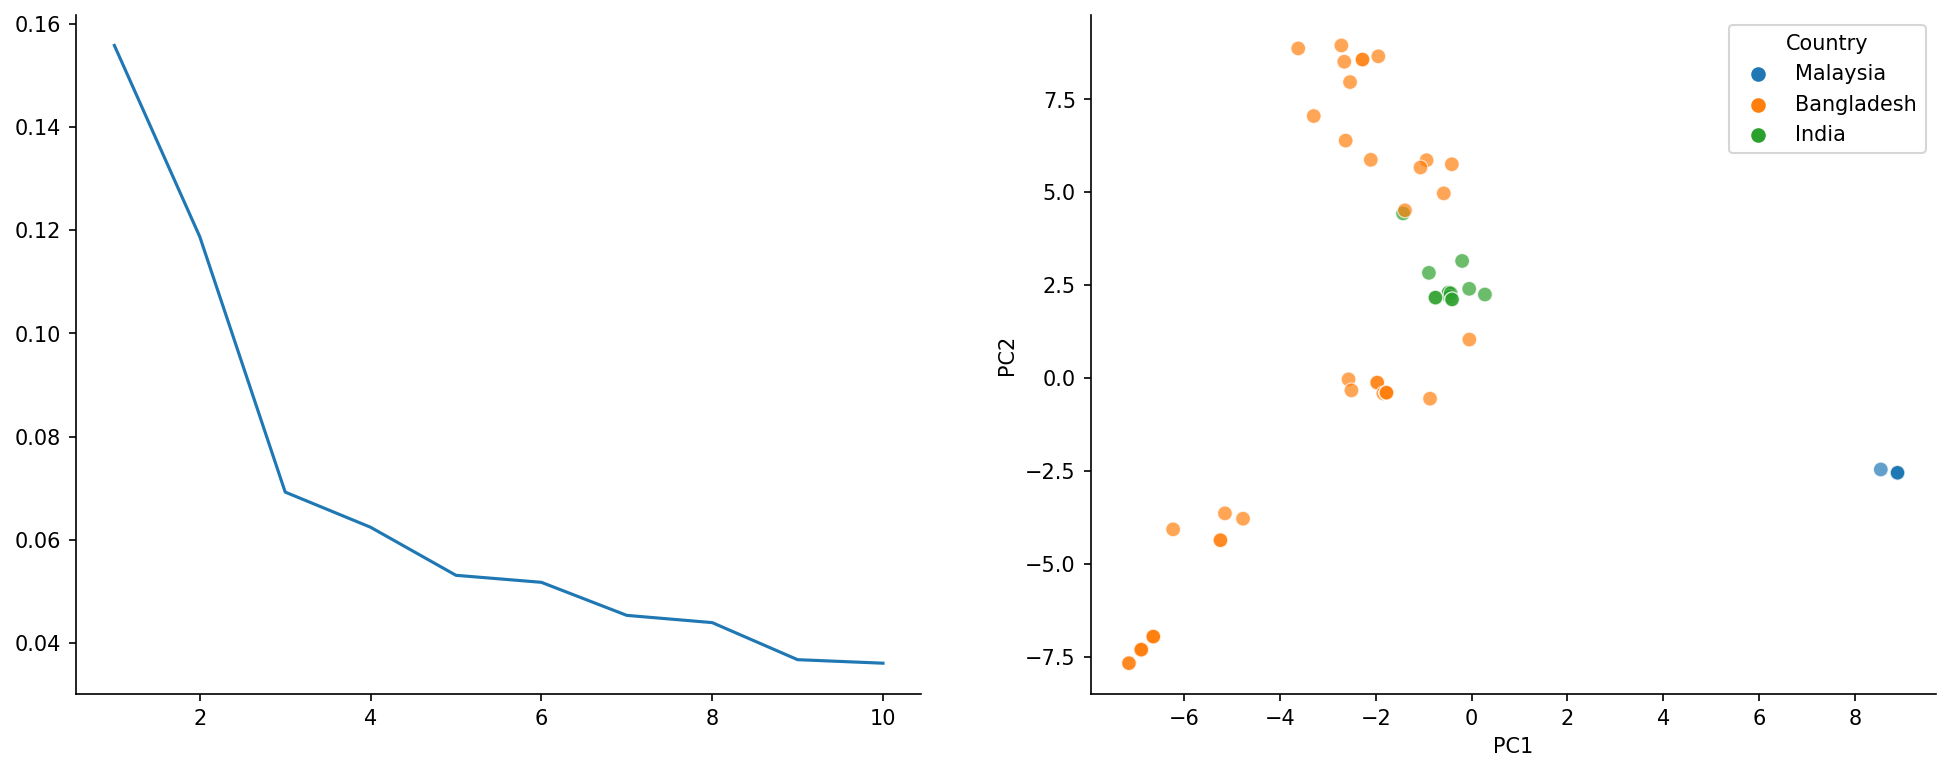

In [14]:
_, pca_df = two_comp_PCA(input_mat, "Country")

In [177]:
#X_snps_bgd, pca_df_bgd = two_comp_PCA(snp_matrix, "Clade")

In [218]:
for i in range(X_snps_bgd.shape[1]):
    
    res = st.spearmanr(pca_df_bgd.PC1, X_snps_bgd[:, i])
    if res[1] < 0.01:
        print(snp_sites[i], res[0])

99 -0.4940514035437881
181 0.5822451628342402
190 -0.8681239025246215
683 -0.8319360252589093
738 -0.8681239025246215
846 -0.8681239025246215
854 -0.8303821008072609
942 -0.8681239025246215
1170 0.5822451628342402
1173 -0.6908387384255946
1599 -0.8681239025246215
1878 -0.6908387384255946
1917 0.5822451628342402
1963 0.5822451628342402
2052 -0.8388892004910621
2112 -0.8134485580309335


In [158]:
# B_clades = P_not_missing.loc[(~pd.isnull(P_not_missing["Clade"])) & (P_not_missing.Country == "Bangladesh")].reset_index(drop=True)
# B_clades, B_clades_sites = filter_sequences(B_clades, "P_seq", maf_thresh=0)

# X_B_clades, pca_df_B_clades = two_comp_PCA(B_clades, "P_seq_one_hot", "Clade")

# Perform logistic regression to separate the Bangladesh clades

## Keeping LASSO here only to show that regularization parameter approaches 0

In [39]:
pca = PCA(3)
pca.fit(np.cov(input_mat.values))
eigenvec = pca.components_.T

X = np.concatenate([input_mat.values, eigenvec], axis=1)
X.shape

(77, 186)

In [40]:
# check that it's in the same order
assert sum(metadata.query("ID in @isolates_for_model").ID.values != isolates_for_model) == 0

y = metadata.query("ID in @isolates_for_model").Country.map({"Malaysia": 0, "India": 1, "Bangladesh": 2}).values

In [42]:
lasso_cv = LogisticRegressionCV(penalty='l1', Cs=1/np.logspace(-10, 10, 1000), solver="liblinear", cv=5, max_iter=100000)
lasso_cv.fit(X, y)

lasso = LogisticRegression(C=lasso_cv.C_[0])
print(f"Fitting Lasso with alpha = {1/lasso_cv.C_[0]}")
lasso.fit(X, y)

lasso_coef = np.squeeze(lasso.coef_)

/home/sak0914/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sak0914/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sak0914/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sak0914/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting Lasso with alpha = 1e-10


In [200]:
logreg = LogisticRegression(penalty='none')
logreg.fit(X=X_snps_bgd, y=(pca_df_bgd.Clade == "B-1").astype(int))
logreg_coef = np.squeeze(logreg.coef_)

coef_df = pd.DataFrame({"pos": snp_sites, "coef": logreg_coef})
b1_clades = coef_df.query("coef > 0").sort_values("coef", ascending=False).reset_index(drop=True)
b2_clades = coef_df.query("coef < 0").sort_values("coef").reset_index(drop=True)

In [201]:
# building the model and fitting the data
#log_reg = sm.Logit((pca_df_bgd.Clade == "B-1").astype(int), X_snps_bgd).fit()

# Looked for natural breaks in the coefficient magnitudes

## B-1 clade: 1746, 1041
## B-2 clade: 190, 738, 1599, 846, 942, 854